# Phase 2: Exploratory Data Analysis (EDA) & Preprocessing

This section focuses on data management for a high-dimensional survey-style dataset (617 variables):

- **Understand the target** (`WEIGHTLBTC_A`: weight in pounds)
- **Handle missing data** by quantifying missingness patterns and identifying likely skip-pattern variables
- **Early feature selection** using the provided variable descriptions (the “Variable Names” sheet)
- **Scaling** numeric variables to support MSE-based evaluation (via `StandardScaler`)

In [5]:
# ---- Config: dataset path + target column ----
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

DATA_PATH = Path("/Users/alexandrebredillot/Documents/GitHub/ML-Assignement/training_dataset.xlsx")
TARGET_REQUESTED = "WEIGHTLBTC_A"  # assignment target
METADATA_SHEET = "variable names"

# Re-load df defensively (keeps this section runnable even if earlier cells change)
df = pd.read_excel(DATA_PATH)
print("Loaded df:", df.shape)

# Target resolution (exact, case-insensitive, and fallback suggestions)
_lowered = {c.lower(): c for c in df.columns}
if TARGET_REQUESTED in df.columns:
    TARGET = TARGET_REQUESTED
elif TARGET_REQUESTED.lower() in _lowered:
    TARGET = _lowered[TARGET_REQUESTED.lower()]
else:
    # fallback: find weight-like columns
    weight_like = [c for c in df.columns if any(k in c.lower() for k in ["weight", "wgt", "lb"])]
    raise ValueError(f"Target {TARGET_REQUESTED!r} not found. Weight-like candidates: {weight_like[:30]}")

print("Resolved TARGET:", TARGET)

Loaded df: (20340, 617)
Resolved TARGET: WEIGHTLBTC_A


Target dtype: int64
Missing target %: 0.0


count    20340.000000
mean       177.082301
std         39.265938
min        100.000000
25%        148.000000
50%        174.000000
75%        200.000000
max        299.000000
Name: WEIGHTLBTC_A, dtype: float64

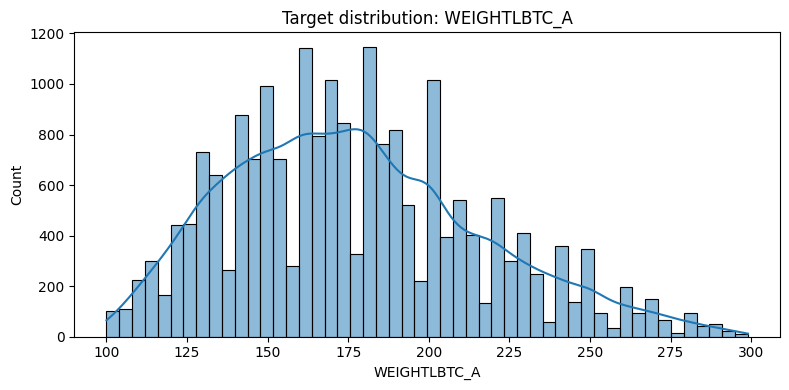

Target quantiles:


,WEIGHTLBTC_A
0.00,100.0
0.01,107.0
0.05,120.0
0.50,174.0
0.95,250.0
0.99,280.0
1.00,299.0


In [2]:
# ---- 2.1 Understand the target ----
y = df[TARGET]
print("Target dtype:", y.dtype)
print("Missing target %:", round(float(y.isna().mean()) * 100, 2))

display(y.describe(include="all"))

# Distribution (drop NaNs for plotting)
plt.figure(figsize=(8, 4))
sns.histplot(y.dropna(), bins=50, kde=True)
plt.title(f"Target distribution: {TARGET}")
plt.xlabel(TARGET)
plt.tight_layout()
plt.show()

# Simple outlier view (robust quantiles)
qs = y.dropna().quantile([0.0, 0.01, 0.05, 0.5, 0.95, 0.99, 1.0])
print("Target quantiles:")
display(qs.to_frame(name=TARGET))

Overall missingness:
  variables: 617
  rows: 20340
  completely-empty columns: 3
  completely-full columns: 196

Top 30 variables by missing %:


,missing_rate,missing_%,dtype
ADVACTIVE_A,0.000000,0.000000,int64
ADVEAT_A,0.000000,0.000000,int64
ADVWGTPRG_A,0.000000,0.000000,int64
AFNOW,0.259784,25.978368,float64
AFVETTRN_A,0.893068,89.306785,float64
AFVET_A,0.000000,0.000000,int64
AGE65,0.996657,99.665683,float64
AGEP_A,0.000000,0.000000,int64
ANGEV_A,0.000000,0.000000,int64
ANIMALWLK_A,0.000000,0.000000,int64


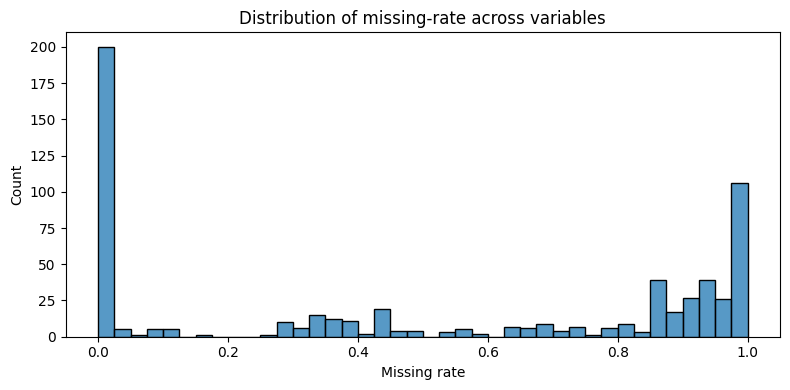

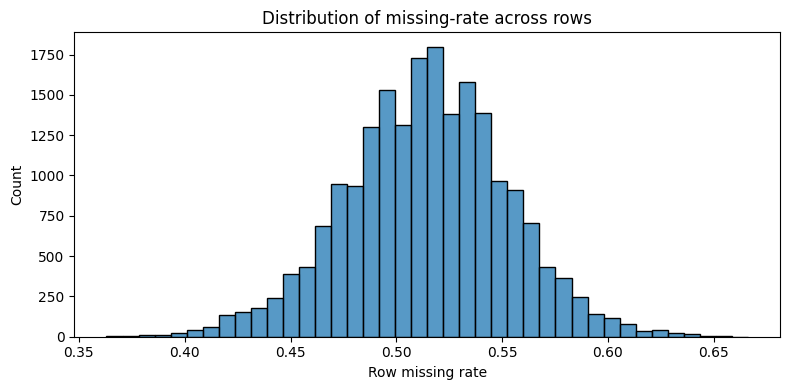

In [3]:
# ---- 2.2 Missing data overview ----
missing_rate = df.isna().mean().sort_values(ascending=False)
missing_df = pd.DataFrame({
    "missing_rate": missing_rate,
    "missing_%": 100.0 * missing_rate,
    "dtype": df.dtypes.astype(str),
})

print("Overall missingness:")
print("  variables:", df.shape[1])
print("  rows:", df.shape[0])
print("  completely-empty columns:", int((missing_rate == 1.0).sum()))
print("  completely-full columns:", int((missing_rate == 0.0).sum()))

print("\nTop 30 variables by missing %:")
display(missing_df.head(30))

# Missingness distribution across variables
plt.figure(figsize=(8, 4))
sns.histplot(missing_rate.values, bins=40)
plt.title("Distribution of missing-rate across variables")
plt.xlabel("Missing rate")
plt.tight_layout()
plt.show()

# Missingness per row (how many fields are missing in each record)
row_missing = df.isna().mean(axis=1)
plt.figure(figsize=(8, 4))
sns.histplot(row_missing.values, bins=40)
plt.title("Distribution of missing-rate across rows")
plt.xlabel("Row missing rate")
plt.tight_layout()
plt.show()

In [4]:
# ---- 2.3 Missingness + metadata (Variable Names sheet) ----
var_info = pd.read_excel(DATA_PATH, sheet_name=METADATA_SHEET).copy()
if not {"Variable code", "Variable name"}.issubset(var_info.columns):
    raise ValueError(f"Unexpected metadata columns: {list(var_info.columns)}")

var_info["Variable code"] = var_info["Variable code"].astype(str).str.strip()
var_info["Variable name"] = var_info["Variable name"].astype(str).str.strip()

# Join missingness to metadata (some df columns may not have a label; keep them too)
meta = (
    missing_df.reset_index(names="Variable code")
    .merge(var_info, on="Variable code", how="left")
    .rename(columns={"Variable name": "description"})
)
meta["description"] = meta["description"].fillna("")

print("Metadata coverage:")
print("  df columns:", df.shape[1])
print("  metadata rows:", var_info.shape[0])
print("  matched descriptions:", int((meta["description"].str.len() > 0).sum()))

print("\nTop 30 missing variables with descriptions:")
display(meta.sort_values("missing_rate", ascending=False).head(30))

# Heuristic: likely skip-pattern variables (common in survey data)
skip_keywords = ["recent", "past", "last", "since", "during", "if", "ever", "times", "days", "weeks", "months", "year", "visited", "took", "smoke", "drink", "exercise"]
meta["is_likely_skip_pattern"] = meta["description"].str.lower().apply(lambda s: any(k in s for k in skip_keywords))

print("\nHigh-missing & likely skip-pattern (missing >= 50%):")
display(meta[(meta["missing_rate"] >= 0.5) & (meta["is_likely_skip_pattern"])].sort_values("missing_rate", ascending=False).head(30))

Metadata coverage:
  df columns: 617
  metadata rows: 617
  matched descriptions: 616

Top 30 missing variables with descriptions:


,Variable code,missing_rate,missing_%,dtype,description
49,CHFLG_A,1.000000,100.000000,float64,Child Flag A
341,OGFLG_A,1.000000,100.000000,float64,Other Government Flag A
439,PRPLCOV2_C_A,1.000000,100.000000,float64,Primary Primary Coverage 2 C A
50,CHHDHP_A,0.999902,99.990167,float64,Child HDHP A
273,LARYNAGETC_A,0.999853,99.985251,float64,Laryngeal Cancer Age TC A
183,GALLBAGETC_A,0.999853,99.985251,float64,Gallbladder Cancer Age TC A
351,OPFLG_A,0.999853,99.985251,float64,Other Private Flag A
47,CHDEDUC_A,0.999607,99.960669,float64,Child Education A
56,CHXCHNG_A,0.999607,99.960669,float64,Child Exchange A
55,CHPREM_A,0.999607,99.960669,float64,Child Premium A



High-missing & likely skip-pattern (missing >= 50%):


,Variable code,missing_rate,missing_%,dtype,description,is_likely_skip_pattern
98,DIBINSSTYR_A,0.999361,99.936087,float64,Disability Insurance Stay Year A,True
165,FDSNEDAYS_A,0.991839,99.183874,float64,Food Days Not Eating A,True
470,RJWCLSNOSD_A,0.982989,98.298918,float64,Recent Work Classification No Standard Data A,True
472,RJWRKCLSSD_A,0.982989,98.298918,float64,Recent Work Classification Standard Data A,True
84,CVDSEV_A,0.980138,98.013766,float64,CVD Severity A,True
209,HILASTMY_A,0.979154,97.915438,float64,History Last My A,True
471,RJWKCLSOFT_A,0.976008,97.600787,float64,Recent Work Classification Soft A,True
609,WRKCLSOFT_A,0.975418,97.541790,float64,Work Classification Soft A,True
57,CIG30D_A,0.974533,97.453294,float64,Cigarette Last 30 Days A,True
522,SMK30D_A,0.972616,97.261554,float64,Smoking Last 30 Days A,True


# Phase 3: Model Development & Hyperparameter Tuning

Constraints for this assignment:
- Stay within course scope (linear models, decision trees, and ensemble trees).
- Use consistent preprocessing (imputation + one-hot encoding + **scaling**) inside each model pipeline.
- Hyperparameter tuning via `GridSearchCV` / `RandomizedSearchCV` using **MSE** as the primary metric.

In [6]:
# ---- 3.1 Build X/y with early pruning ----
from IPython.display import display
from sklearn.model_selection import train_test_split

# Drop rows with missing target (cannot train on them)
df_model = df.copy()
before = len(df_model)
df_model = df_model[df_model[TARGET].notna()].copy()
print(f"Rows with non-missing target: {len(df_model)} / {before} (dropped {before-len(df_model)})")

y = df_model[TARGET]
X = df_model.drop(columns=[TARGET])
print("Initial X shape:", X.shape)

# 1) Drop columns that are completely empty
empty_cols = [c for c in X.columns if X[c].isna().all()]
if empty_cols:
    print("Dropping completely-empty columns:", len(empty_cols))
    X = X.drop(columns=empty_cols)

# 2) Drop columns with extreme missingness (keep threshold conservative)
missing_threshold = 0.95
miss = X.isna().mean()
high_missing = miss[miss >= missing_threshold].index.tolist()
if high_missing:
    print(f"Dropping high-missing columns (>= {missing_threshold:.0%}):", len(high_missing))
    X = X.drop(columns=high_missing)

# 3) Drop constant / near-constant columns (ignoring NaNs)
nunique = X.nunique(dropna=True)
constant_cols = nunique[nunique <= 1].index.tolist()
if constant_cols:
    print("Dropping constant columns:", len(constant_cols))
    X = X.drop(columns=constant_cols)

# 4) Drop obvious ID-like high-cardinality object columns
object_cols = X.select_dtypes(include=["object"]).columns
id_like = [c for c in object_cols if X[c].nunique(dropna=True) > 0.9 * len(X)]
if id_like:
    print("Dropping ID-like columns:", id_like)
    X = X.drop(columns=id_like)

print("After missing/constant/ID pruning:", X.shape)

Rows with non-missing target: 20340 / 20340 (dropped 0)
Initial X shape: (20340, 616)
Dropping completely-empty columns: 3
Dropping high-missing columns (>= 95%): 129
Dropping constant columns: 4
Dropping ID-like columns: ['HHX']
After missing/constant/ID pruning: (20340, 479)


In [7]:
# ---- 3.2 Early feature selection using descriptions (conservative) ----
import re

# Build description map from the metadata we already loaded in Phase 2 (fallback to re-load)
if "var_info" in globals() and {"Variable code","Variable name"}.issubset(var_info.columns):
    _var_info = var_info.copy()
else:
    _var_info = pd.read_excel(DATA_PATH, sheet_name=METADATA_SHEET).copy()
    _var_info["Variable code"] = _var_info["Variable code"].astype(str).str.strip()
    _var_info["Variable name"] = _var_info["Variable name"].astype(str).str.strip()

desc_map = dict(zip(_var_info["Variable code"], _var_info["Variable name"]))

def select_features_by_description(columns: list[str], desc_map: dict[str, str]):
    """Drop clearly administrative / survey-design / ID-like fields using provided descriptions."""
    keep = set(columns)

    def _desc(c: str) -> str:
        return str(desc_map.get(c, "")).strip()

    # Hard drops by variable code (known administrative fields)
    hard_drop_codes = {"HHX", "WTFA_A", "RECTYPE"}
    for c in list(keep):
        if c in hard_drop_codes:
            keep.remove(c)

    # Conservative keyword drops (metadata / survey mechanics, not predictors)
    keyword_patterns = [
        r"\bweight\b",
        r"\brecord type\b",
        r"\bhousehold\b",
        r"\bidentifier\b",
        r"\binterview\b",
        r"\bsample design\b",
        r"\bproxy\b",
        r"\bavailability\b",
    ]
    keyword_re = re.compile("|".join(keyword_patterns), flags=re.IGNORECASE)
    for c in list(keep):
        d = _desc(c)
        if d and keyword_re.search(d):
            keep.remove(c)

    # Remove redundant variants when a 'Standard Data' version exists
    def _base_desc(d: str) -> str:
        d = re.sub(r"\s+Standard Data\s*$", "", d, flags=re.IGNORECASE)
        d = re.sub(r"\s+No Standard Data\s*$", "", d, flags=re.IGNORECASE)
        d = re.sub(r"\s+Soft\s*$", "", d, flags=re.IGNORECASE)
        d = re.sub(r"\s+[A-Z]$", "", d)
        return d.strip().lower()

    groups: dict[str, list[str]] = {}
    for c in columns:
        d = _desc(c)
        if not d:
            continue
        base = _base_desc(d)
        if base:
            groups.setdefault(base, []).append(c)

    for base, cs in groups.items():
        if len(cs) < 2:
            continue
        standard = [c for c in cs if re.search(r"Standard Data\s*[A-Z]?$", _desc(c), flags=re.IGNORECASE)]
        if not standard:
            continue
        for c in cs:
            d = _desc(c)
            if re.search(r"(Soft|No Standard Data)\s*[A-Z]?$", d, flags=re.IGNORECASE):
                keep.discard(c)

    dropped = [c for c in columns if c not in keep]
    return sorted(keep), dropped

selected_cols, dropped_cols = select_features_by_description(list(X.columns), desc_map)
X = X[selected_cols]
print("After description-based feature selection:")
print("  kept:", X.shape[1])
print("  dropped:", len(dropped_cols))
if dropped_cols:
    preview = pd.DataFrame({"code": dropped_cols[:30], "description": [desc_map.get(c, "") for c in dropped_cols[:30]]})
    display(preview)

After description-based feature selection:
  kept: 471
  dropped: 8


,code,description
0,INTV_QRT,Interview Quarter
1,HOUGVASST_A,Household Gas Status A
2,FDSWEIGHT_A,Food Weight A
3,NOWWGTPRG_A,Now Weight Prog A
4,ADVWGTPRG_A,Advanced Weight Prog A
5,AVAIL_A,Availability A
6,INTV_MON,Interview Month
7,WTFA_A,Weight Factor A


In [8]:
# ---- 3.3 Train/test split and preprocessing (scaling for MSE) ----
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import mean_squared_error

# Hold-out set for final evaluation (Phase 4)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
 )
print("Train:", X_train.shape, "Test:", X_test.shape)

numeric_features = X_train.select_dtypes(include=[np.number]).columns
categorical_features = X_train.select_dtypes(exclude=[np.number]).columns
print("Numeric features:", len(numeric_features), "| Categorical features:", len(categorical_features))

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])
preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)

cv = KFold(n_splits=5, shuffle=True, random_state=42)
SCORING = {"mse": "neg_mean_squared_error"}

Train: (16272, 471) Test: (4068, 471)
Numeric features: 471 | Categorical features: 0


In [ ]:
# ---- 3.4 Baseline models (course-scope) with k-fold CV (MSE) ----
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

def evaluate_model(name, estimator):
    pipe = Pipeline(steps=[("preprocess", preprocess), ("model", estimator)])
    scores = cross_validate(pipe, X_train, y_train, cv=cv, scoring=SCORING, n_jobs=-1)
    mse = -scores["test_mse"]
    return {
        "model": name,
        "cv_mse_mean": float(mse.mean()),
        "cv_mse_std": float(mse.std()),
    }

models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(random_state=42),
    "Lasso": Lasso(random_state=42, max_iter=20000),
    "ElasticNet": ElasticNet(random_state=42, max_iter=20000),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "RandomForest": RandomForestRegressor(random_state=42, n_jobs=-1),
}

baseline_results = pd.DataFrame([evaluate_model(n, m) for n, m in models.items()])\
    .sort_values("cv_mse_mean", ascending=True)\
    .reset_index(drop=True)
print("Baseline CV results (lower MSE is better):")
display(baseline_results)

In [ ]:
# ---- 3.5 Hyperparameter tuning (MSE) ----
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform

# We tune a small set of models to keep runtime reasonable.

search_spaces = {
    "Ridge": (
        Ridge(random_state=42),
        {"model__alpha": np.logspace(-3, 3, 13)},
        "grid",
    ),
    "ElasticNet": (
        ElasticNet(random_state=42, max_iter=20000),
        {
            "model__alpha": np.logspace(-4, 1, 10),
            "model__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9],
        },
        "grid",
    ),
    "DecisionTree": (
        DecisionTreeRegressor(random_state=42),
        {
            "model__max_depth": randint(2, 40),
            "model__min_samples_split": randint(2, 50),
            "model__min_samples_leaf": randint(1, 20),
        },
        "random",
    ),
    "RandomForest": (
        RandomForestRegressor(random_state=42, n_jobs=-1),
        {
            "model__n_estimators": randint(200, 800),
            "model__max_depth": randint(5, 50),
            "model__min_samples_leaf": randint(1, 10),
            "model__max_features": ["sqrt", "log2", None],
        },
        "random",
    ),
}

tuning_results = []
best_estimators = {}

for name, (estimator, params, mode) in search_spaces.items():
    pipe = Pipeline(steps=[("preprocess", preprocess), ("model", estimator)])
    if mode == "grid":
        search = GridSearchCV(
            pipe,
            params,
            scoring="neg_mean_squared_error",
            cv=cv,
            n_jobs=-1,
        )
    else:
        search = RandomizedSearchCV(
            pipe,
            params,
            n_iter=25,
            scoring="neg_mean_squared_error",
            cv=cv,
            random_state=42,
            n_jobs=-1,
        )

    print(f"Tuning {name}...")
    search.fit(X_train, y_train)
    best_mse = -float(search.best_score_)
    tuning_results.append({"model": name, "cv_mse_best": best_mse, "best_params": search.best_params_})
    best_estimators[name] = search.best_estimator_

tuning_df = pd.DataFrame(tuning_results).sort_values("cv_mse_best", ascending=True).reset_index(drop=True)
print("\nTuned results (lower MSE is better):")
display(tuning_df)

# Phase 4: Evaluation and Final Selection

- Use **k-fold CV MSE** to select the best model consistently.
- Report **hold-out test MSE** as a final sanity check (not used for tuning).

In [ ]:
# ---- 4.1 Pick best tuned model + evaluate on hold-out test (MSE) ----
import joblib

if len(tuning_df) == 0:
    raise RuntimeError("No tuned models found; run Phase 3.5 first.")

best_name = tuning_df.loc[0, "model"]
best_estimator = best_estimators[best_name]
print("Selected best model:", best_name)

# Fit on full training set and evaluate on hold-out test
best_estimator.fit(X_train, y_train)
y_pred = best_estimator.predict(X_test)
test_mse = float(mean_squared_error(y_test, y_pred))
print("Hold-out Test MSE:", round(test_mse, 4))

# Save model for submission
MODEL_OUT = Path("/Users/alexandrebredillot/Documents/GitHub/ML-Assignement/final_model.joblib")
joblib.dump(best_estimator, MODEL_OUT)
print("Saved model to:", MODEL_OUT)

# Phase 5: Documentation & Submission (Report ≤ 2500 words)

Your report should explicitly include:
- The **target definition** and missingness handling choices
- **Feature selection rationale** (description-based + high-missing/constant/ID-like pruning)
- Every **algorithm tested** (even those that performed poorly) with CV MSE results
- The **hyperparameter search** strategy and final selected model
- Final metrics: **CV MSE (mean±std)** and **hold-out test MSE**
- Submission checklist: notebook/code + `final_model.joblib` + report PDF before **9 Jan 2026**

In [ ]:
# Feature selection (early): use provided variable names/descriptions
import re
import pandas as pd

# Load code -> description mapping from the same Excel file (sheet: 'variable names')
_meta_path = "/Users/alexandrebredillot/Documents/GitHub/EXP_GO/EDH - /Machine Learning/assignement/training_dataset.xlsx"
var_info = pd.read_excel(_meta_path, sheet_name="variable names")
var_info["Variable code"] = var_info["Variable code"].astype(str).str.strip()
var_info["Variable name"] = var_info["Variable name"].astype(str).str.strip()

desc_map = dict(zip(var_info["Variable code"], var_info["Variable name"]))
print("Loaded variable metadata:", var_info.shape, "| mapped codes:", len(desc_map))

def select_features_by_description(df_features: pd.DataFrame, desc_map: dict[str, str]):
    """Drop clearly administrative / survey-design / ID-like fields using provided descriptions.

    Keeps the logic conservative: we only drop when the description strongly suggests
    the field is metadata rather than a meaningful predictor.
    """
    cols = list(df_features.columns)
    keep = set(cols)

    def _desc(c: str) -> str:
        return str(desc_map.get(c, "")).strip()

    # 1) Hard drops by variable code (known administrative fields)
    hard_drop_codes = {
        "HHX",      # household identifier
        "WTFA_A",   # survey weight
        "RECTYPE",  # record type
    }
    for c in list(keep):
        if c in hard_drop_codes:
            keep.remove(c)

    # 2) Drops by description keywords (conservative)
    keyword_patterns = [
        r"\bweight\b",
        r"\brecord type\b",
        r"\bhousehold\b",
        r"\bidentifier\b",
        r"\binterview\b",
        r"\bsample design\b",
        r"\bproxy\b",
        r"\bavailability\b",
    ]
    keyword_re = re.compile("|".join(keyword_patterns), flags=re.IGNORECASE)

    for c in list(keep):
        d = _desc(c)
        if d and keyword_re.search(d):
            keep.remove(c)

    # 3) Remove redundant variants when a 'Standard Data' version exists
    # We group by a base description where we remove the variant qualifier.
    def _base_desc(d: str) -> str:
        d = re.sub(r"\s+Standard Data\s*$", "", d, flags=re.IGNORECASE)
        d = re.sub(r"\s+No Standard Data\s*$", "", d, flags=re.IGNORECASE)
        d = re.sub(r"\s+Soft\s*$", "", d, flags=re.IGNORECASE)
        d = re.sub(r"\s+[A-Z]$", "", d)  # trailing 'A' (common in this dataset)
        return d.strip().lower()

    # Build groups by base description
    groups: dict[str, list[str]] = {}
    for c in cols:
        d = _desc(c)
        if not d:
            continue
        base = _base_desc(d)
        if base:
            groups.setdefault(base, []).append(c)

    for base, cs in groups.items():
        if len(cs) < 2:
            continue
        # if there is a standard-data column in the group, drop the soft/no-std ones
        standard = [c for c in cs if re.search(r"Standard Data\s*[A-Z]?$", _desc(c), flags=re.IGNORECASE)]
        if not standard:
            continue
        for c in cs:
            d = _desc(c)
            if re.search(r"(Soft|No Standard Data)\s*[A-Z]?$", d, flags=re.IGNORECASE):
                if c in keep:
                    keep.remove(c)

    dropped = [c for c in cols if c not in keep]
    return sorted(keep), dropped

selected_cols, dropped_cols = select_features_by_description(df, desc_map)
print("Early feature selection:")
print("  original columns:", df.shape[1])
print("  kept columns:", len(selected_cols))
print("  dropped columns:", len(dropped_cols))
if dropped_cols:
    preview = [(c, desc_map.get(c, "")) for c in dropped_cols[:25]]
    print("\nDropped (first 25):")
    for c, d in preview:
        print(f"  {c}: {d}")

In [ ]:
# Lasso + ElasticNet (with preprocessing + CV)
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LassoCV, ElasticNetCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import difflib

# --- Choose target column ---
requested_target = "weightlbtc_A"
target_column = None

# 1) exact match
if requested_target in df.columns:
    target_column = requested_target
else:
    # 2) case-insensitive match
    lowered = {c.lower(): c for c in df.columns}
    if requested_target.lower() in lowered:
        target_column = lowered[requested_target.lower()]

if target_column is None:
    # 3) show helpful suggestions and stop
    close = difflib.get_close_matches(requested_target, df.columns, n=10, cutoff=0.6)
    contains = [c for c in df.columns if any(k in c.lower() for k in ["weight", "wgt", "lb"])][:30]
    raise ValueError(
        "Target column not found. "
        f"Requested: {requested_target!r}. "
        f"Close matches: {close}. "
        f"Columns containing 'weight'/'wgt'/'lb' (first 30): {contains}"
    )

print("Target:", target_column)
print("df shape:", df.shape)
print("Target dtype:", df[target_column].dtype, "| missing:", df[target_column].isna().mean().round(4))

# --- Build X/y ---
X = df.drop(columns=[target_column])
y = df[target_column]

# Apply early feature selection (description-based) if available
try:
    if "selected_cols" in globals():
        # selected_cols was computed on df (including target); keep only those present in X
        _keep = [c for c in selected_cols if c in X.columns]
        dropped_early = [c for c in X.columns if c not in set(_keep)]
        X = X[_keep]
        print(f"Applied early feature selection -> kept {X.shape[1]} predictors; dropped {len(dropped_early)}")
except Exception as e:
    print("Early feature selection skipped due to:", repr(e))

# Drop obvious ID-like columns (very high cardinality strings)
object_cols = X.select_dtypes(include=["object"]).columns.tolist()
id_like = [c for c in object_cols if X[c].nunique(dropna=True) > 0.9 * len(X)]
if id_like:
    print("Dropping ID-like columns:", id_like)
    X = X.drop(columns=id_like)

# Basic split (reproducible)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
 )

# Drop features that are entirely missing in the TRAIN split (avoids imputer warnings)
all_missing = [c for c in X_train.columns if X_train[c].isna().all()]
if all_missing:
    print("Dropping all-missing columns (train):", all_missing)
    X_train = X_train.drop(columns=all_missing)
    X_test = X_test.drop(columns=all_missing, errors="ignore")

numeric_features = X_train.select_dtypes(include=[np.number]).columns
categorical_features = X_train.select_dtypes(exclude=[np.number]).columns

# IMPORTANT for MSE-based evaluation: scale numeric features (StandardScaler)
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
 ])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
 ])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
 )

# --- Lasso (CV) ---
# Use alphas=100 to match sklearn's upcoming default and silence the deprecation warning
lasso = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LassoCV(alphas=100, cv=5, random_state=42, n_jobs=-1, max_iter=20000)),
 ])

lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)

rmse_lasso = float(np.sqrt(mean_squared_error(y_test, y_pred_lasso)))

print("\nLassoCV")
print("  alpha:", float(lasso.named_steps["model"].alpha_))
print("  R2:", round(r2_score(y_test, y_pred_lasso), 4))
print("  MAE:", round(mean_absolute_error(y_test, y_pred_lasso), 4))
print("  RMSE:", round(rmse_lasso, 4))

# --- ElasticNet (CV) ---
# ElasticNetCV cross-validates both alpha and l1_ratio
enet = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", ElasticNetCV(
        l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9],
        alphas=100,
        cv=5,
        random_state=42,
        n_jobs=-1,
        max_iter=20000,
    )),
 ])

enet.fit(X_train, y_train)
y_pred_enet = enet.predict(X_test)

rmse_enet = float(np.sqrt(mean_squared_error(y_test, y_pred_enet)))

print("\nElasticNetCV")
print("  alpha:", float(enet.named_steps["model"].alpha_))
print("  l1_ratio:", float(enet.named_steps["model"].l1_ratio_))
print("  R2:", round(r2_score(y_test, y_pred_enet), 4))
print("  MAE:", round(mean_absolute_error(y_test, y_pred_enet), 4))
print("  RMSE:", round(rmse_enet, 4))

# --- Top coefficients (interpretability) ---
def top_coefficients(pipeline, top_k=20):
    pre = pipeline.named_steps["preprocess"]
    model = pipeline.named_steps["model"]
    try:
        feature_names = pre.get_feature_names_out()
    except Exception:
        feature_names = None
    coef = model.coef_
    if feature_names is None:
        print("(Could not fetch feature names; showing coefficient indices)")
        idx = np.argsort(np.abs(coef))[::-1][:top_k]
        for i in idx:
            print(f"  idx={i:>5} coef={coef[i]: .6f}")
        return
    idx = np.argsort(np.abs(coef))[::-1][:top_k]
    for i in idx:
        print(f"  {feature_names[i]:<40} coef={coef[i]: .6f}")

print("\nTop Lasso coefficients:")
top_coefficients(lasso, top_k=20)

print("\nTop ElasticNet coefficients:")
top_coefficients(enet, top_k=20)

Target: WEIGHTLBTC_A
df shape: (20340, 617)
Target dtype: int64 | missing: 0.0
Dropping ID-like columns: ['HHX']
Dropping all-missing columns (train): ['OGFLG_A', 'CHFLG_A', 'PRPLCOV2_C_A']

LassoCV
  alpha: 0.21886402297465457
  R2: 0.7036
  MAE: 13.3574
  RMSE: 21.4518

ElasticNetCV
  alpha: 0.21150751743457932
  l1_ratio: 0.9
  R2: 0.7052
  MAE: 13.4097
  RMSE: 21.3921

Top Lasso coefficients:
  BMICAT_A                                 coef= 25.980913
  HEIGHTTC_A                               coef= 9.334418
  SEX_A                                    coef=-7.850243
  ADVEAT_A                                 coef=-3.308423
  AGEP_A                                   coef=-2.081097
  SCHCURENR_A                              coef= 1.583823
  PHSTAT_A                                 coef= 1.285172
  DIFF_A                                   coef= 1.067282
  NATUSBORN_A                              coef=-1.064115
  HYPEV_A                                  coef=-0.920816
  RACEALLP_A       

Explained variance ratio (PC1, PC2): [0.0813 0.0402]


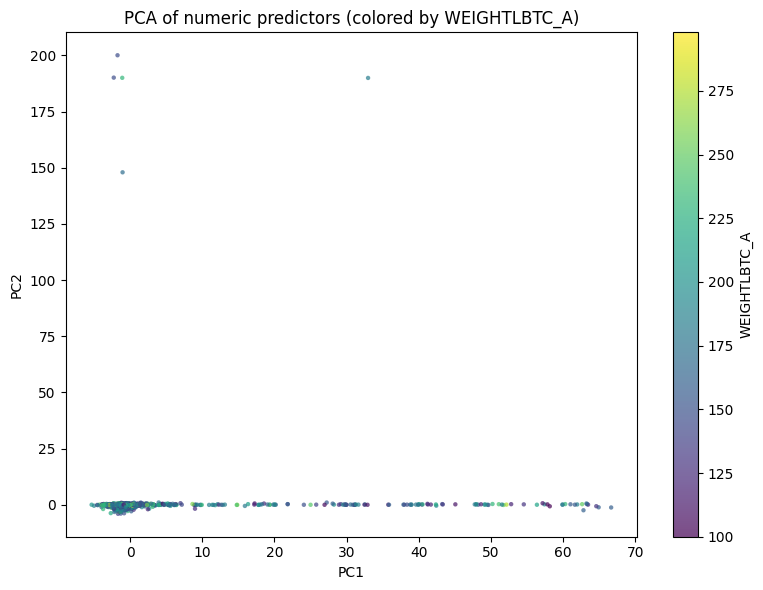

In [13]:
# PCA plot (numeric features only)
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# We'll do PCA on numeric predictors only (after the same X_train/X_test cleanup already done above).
X_num_train = X_train.select_dtypes(include=[np.number])
X_num_test = X_test.select_dtypes(include=[np.number])

# Impute + scale numeric features
num_pca_prep = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

X_num_train_scaled = num_pca_prep.fit_transform(X_num_train)
X_num_test_scaled = num_pca_prep.transform(X_num_test)

pca = PCA(n_components=2, random_state=42)
Z_train = pca.fit_transform(X_num_train_scaled)
Z_test = pca.transform(X_num_test_scaled)

print("Explained variance ratio (PC1, PC2):", np.round(pca.explained_variance_ratio_, 4))

plt.figure(figsize=(8, 6))
sc = plt.scatter(
    Z_test[:, 0],
    Z_test[:, 1],
    c=y_test,
    s=10,
    alpha=0.7,
    cmap="viridis",
    edgecolors="none",
 )
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"PCA of numeric predictors (colored by {target_column})")
cb = plt.colorbar(sc)
cb.set_label(target_column)
plt.tight_layout()
plt.show()

In [16]:
# Rank original numeric features by contribution to variance captured by PC1/PC2
import pandas as pd
import numpy as np

feature_names = X_num_train.columns.to_numpy()
loadings = pca.components_.T  # (n_features, 2) because n_components=2
evr = pca.explained_variance_ratio_[: loadings.shape[1]]

# Contribution score in *explained-variance-ratio* units: sum_k (EVR_k * loading_{feature,k}^2)
contrib = (loadings**2) @ evr
contrib_pc1 = loadings[:, 0] ** 2
contrib_pc2 = loadings[:, 1] ** 2

rank_df = pd.DataFrame({
    "feature": feature_names,
    "pc1_loading": loadings[:, 0],
    "pc2_loading": loadings[:, 1],
    "pc1_contrib(loading^2)": contrib_pc1,
    "pc2_contrib(loading^2)": contrib_pc2,
    "combined_contrib(EVR-weighted)": contrib,
}).sort_values("combined_contrib(EVR-weighted)", ascending=False)

# Cumulative share within the variance captured by PC1+PC2
total_captured = float(evr.sum())
rank_df["cum_contrib(EVR-weighted)"] = rank_df["combined_contrib(EVR-weighted)"].cumsum()
rank_df["cum_%_of_PC1+PC2"] = 100.0 * rank_df["cum_contrib(EVR-weighted)"] / total_captured

top_n = 30
topn_captured = float(rank_df.head(top_n)["combined_contrib(EVR-weighted)"].sum())
topn_pct_of_captured = 100.0 * topn_captured / total_captured
topn_pct_of_total_variance = 100.0 * topn_captured  # since EVR is already a ratio of total variance

print("Explained variance ratio:", np.round(evr, 6), "| total PC1+PC2:", round(total_captured, 6))
print(
    f"Top {top_n} features contribute {topn_captured:.6f} EVR units -> "
    f"{topn_pct_of_captured:.2f}% of the variance captured by PC1+PC2 "
    f"(= {topn_pct_of_total_variance:.2f}% of total variance)."
)
print("\nTop 30 features (descending):")
display(rank_df.head(top_n))

Explained variance ratio: [0.081275 0.040182] | total PC1+PC2: 0.121456
Top 30 features contribute 0.043870 EVR units -> 36.12% of the variance captured by PC1+PC2 (= 4.39% of total variance).

Top 30 features (descending):


,feature,pc1_loading,pc2_loading,pc1_contrib(loading^2),pc2_contrib(loading^2),combined_contrib(EVR-weighted),cum_contrib(EVR-weighted),cum_%_of_PC1+PC2
217,LARYNCAN_A,-0.000820,0.201764,6.720685e-07,4.070858e-02,0.001636,0.001636,1.346813
218,GALLBCAN_A,-0.000829,0.201721,6.872045e-07,4.069143e-02,0.001635,0.003271,2.693059
219,ESOPHCAN_A,-0.000810,0.201204,6.553330e-07,4.048296e-02,0.001627,0.004898,4.032406
211,MOUTHCAN_A,-0.001236,0.200978,1.528771e-06,4.039226e-02,0.001623,0.006521,5.368811
209,PANCRCAN_A,-0.000941,0.200689,8.856951e-07,4.027623e-02,0.001618,0.008139,6.701335
203,STOMACAN_A,-0.000798,0.200665,6.369691e-07,4.026651e-02,0.001618,0.009757,8.033520
225,BLOODCAN_A,-0.000775,0.200609,6.001935e-07,4.024391e-02,0.001617,0.011374,9.364955
224,BONECAN_A,-0.000770,0.200358,5.927747e-07,4.014316e-02,0.001613,0.012987,10.693056
207,RECTUCAN_A,-0.000680,0.199503,4.626618e-07,3.980133e-02,0.001599,0.014587,12.009840
215,LIVERCAN_A,-0.000672,0.198919,4.517734e-07,3.956877e-02,0.001590,0.016177,13.318930


In [19]:
# Ranking of PCA components by explained variance (scree table)
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np

# Fit PCA with the maximum possible number of components
# (limited by min(n_samples, n_features))
max_components = int(min(X_num_train_scaled.shape[0], X_num_train_scaled.shape[1]))
pca_full = PCA(n_components=max_components, random_state=42)
pca_full.fit(X_num_train_scaled)

evr_full = pca_full.explained_variance_ratio_
cum_full = np.cumsum(evr_full)

pc_rank = pd.DataFrame({
    "PC": [f"PC{i+1}" for i in range(len(evr_full))],
    "explained_variance_ratio": evr_full,
    "cumulative_explained_variance": cum_full,
})

print("Top 20 PCs by explained variance:")
display(pc_rank.head(20))

# How many PCs needed for common thresholds (including 98%)
for thr in [0.5, 0.8, 0.9, 0.95, 0.98]:
    k = int(np.searchsorted(cum_full, thr) + 1)
    print(f"PCs needed for {int(thr*100)}% variance: {k}")

Top 20 PCs by explained variance:


,PC,explained_variance_ratio,cumulative_explained_variance
0,PC1,0.081275,0.081275
1,PC2,0.040182,0.121456
2,PC3,0.024523,0.145979
3,PC4,0.020096,0.166075
4,PC5,0.015899,0.181974
5,PC6,0.015080,0.197054
6,PC7,0.014321,0.211375
7,PC8,0.013512,0.224887
8,PC9,0.010397,0.235283
9,PC10,0.009506,0.244789


PCs needed for 50% variance: 79
PCs needed for 80% variance: 250
PCs needed for 90% variance: 339
PCs needed for 95% variance: 402
PCs needed for 98% variance: 462


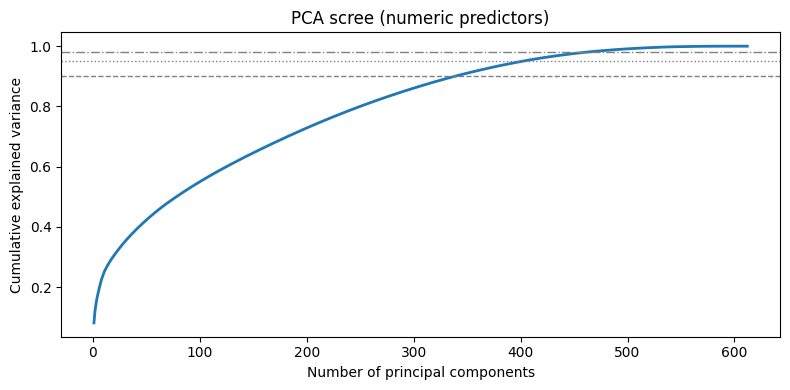

|PC2| quantiles: {'50%': np.float64(0.0995), '90%': np.float64(0.5872), '95%': np.float64(0.9607), '99%': np.float64(1.9168), '99.9%': np.float64(138.3121)}

Top 10 |PC2| points (test set):


,PC1,PC2,WEIGHTLBTC_A
13405,-1.758482,200.048597,146
10317,-2.280210,190.092904,146
17980,-1.105103,190.007863,230
3511,32.973039,189.956628,183
3522,-1.058092,147.956262,170
19593,-1.690712,-4.013660,140
9119,-1.314395,-3.924063,150
15413,-0.844754,-3.773115,151
17261,-2.694733,-3.713309,220
10422,-2.188373,-3.212601,165



PC1+PC2 explained variance: 0.1215


In [20]:
# PCA sanity checks (is PCA "good"?)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Scree curve: cumulative explained variance vs #PCs
plt.figure(figsize=(8, 4))
plt.plot(np.arange(1, len(evr_full) + 1), np.cumsum(evr_full), linewidth=2)
plt.axhline(0.90, color="gray", linestyle="--", linewidth=1)
plt.axhline(0.95, color="gray", linestyle=":", linewidth=1)
plt.axhline(0.98, color="gray", linestyle="-.", linewidth=1)
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA scree (numeric predictors)")
plt.tight_layout()
plt.show()

# 2) Outlier check in PC space (helps explain a "squashed" plot)
pc2_abs = np.abs(Z_test[:, 1])
q = np.quantile(pc2_abs, [0.5, 0.9, 0.95, 0.99, 0.999])
print("|PC2| quantiles:", dict(zip(["50%","90%","95%","99%","99.9%"], np.round(q, 4))))

top_k = 10
idx = np.argsort(pc2_abs)[-top_k:][::-1]
outlier_view = pd.DataFrame({
    "PC1": Z_test[idx, 0],
    "PC2": Z_test[idx, 1],
    target_column: y_test.iloc[idx].values,
}, index=y_test.iloc[idx].index)
print(f"\nTop {top_k} |PC2| points (test set):")
display(outlier_view)

# 3) Quick check: how much variance is in PC1+PC2 (you already printed this, but keeping here)
print("\nPC1+PC2 explained variance:", round(float(pca.explained_variance_ratio_.sum()), 4))

In [21]:
# Correlation analysis + RandomForest feature importance + best prediction score
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# ----------------------------
# 1) Correlation analysis (numeric only)
# ----------------------------
X_num = X_train.select_dtypes(include=[np.number]).copy()
corr = X_num.corrwith(y_train).dropna().sort_values(key=lambda s: s.abs(), ascending=False)

corr_df = pd.DataFrame({"corr_with_target": corr, "abs_corr": corr.abs()}).sort_values("abs_corr", ascending=False)
print("Top 20 numeric features by |correlation| with target:")
display(corr_df.head(20))

# ----------------------------
# 2) RandomForest model + feature importances
# ----------------------------
numeric_features_rf = X_train.select_dtypes(include=[np.number]).columns
categorical_features_rf = X_train.select_dtypes(exclude=[np.number]).columns

rf_preprocess = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), numeric_features_rf),
        (
            "cat",
            Pipeline(steps=[
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True)),
            ]),
            categorical_features_rf,
        ),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
    sparse_threshold=0.3,
 )

rf_model = RandomForestRegressor(
    n_estimators=400,
    random_state=42,
    n_jobs=-1,
    min_samples_leaf=2,
 )

rf = Pipeline(steps=[("preprocess", rf_preprocess), ("model", rf_model)])
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

rmse_rf = float(np.sqrt(mean_squared_error(y_test, y_pred_rf)))
r2_rf = float(r2_score(y_test, y_pred_rf))
mae_rf = float(mean_absolute_error(y_test, y_pred_rf))

print("\nRandomForestRegressor")
print("  R2:", round(r2_rf, 4))
print("  MAE:", round(mae_rf, 4))
print("  RMSE:", round(rmse_rf, 4))

# Feature importance (works for RF)
feature_names_rf = rf.named_steps["preprocess"].get_feature_names_out()
importances = rf.named_steps["model"].feature_importances_
fi = (
    pd.DataFrame({"feature": feature_names_rf, "importance": importances})
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
 )

print("\nTop 30 RandomForest feature importances:")
display(fi.head(30))

# ----------------------------
# 3) Compare models and print best scores
# ----------------------------
def _metrics(y_true, y_pred):
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    return {
        "R2": float(r2_score(y_true, y_pred)),
        "MAE": float(mean_absolute_error(y_true, y_pred)),
        "RMSE": rmse,
    }

scores = pd.DataFrame([
    {"model": "LassoCV", **_metrics(y_test, y_pred_lasso)},
    {"model": "ElasticNetCV", **_metrics(y_test, y_pred_enet)},
    {"model": "RandomForest", **_metrics(y_test, y_pred_rf)},
]).set_index("model").sort_values(["R2", "RMSE"], ascending=[False, True])

print("\nModel comparison on test set:")
display(scores)

best_model = scores.index[0]
print(f"\nBest model by highest R2 (tie-break: lowest RMSE): {best_model}")

Top 20 numeric features by |correlation| with target:


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3057: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)

,corr_with_target,abs_corr
CHXCHNG_A,0.955617,0.955617
MOUTHAGETC_A,-0.892888,0.892888
BMICAT_A,0.737492,0.737492
DIBINSSTYR_A,-0.654952,0.654952
OGHDHP_A,-0.480275,0.480275
SPOUSESEX_A,0.467696,0.467696
HEIGHTTC_A,0.439401,0.439401
CHDEDUC_A,-0.419440,0.419440
ESOPHAGETC_A,0.415934,0.415934
SEX_A,-0.409586,0.409586



RandomForestRegressor
  R2: 0.859
  MAE: 11.095
  RMSE: 14.7938

Top 30 RandomForest feature importances:


,feature,importance
0,BMICAT_A,0.603204
1,HEIGHTTC_A,0.246149
2,SEX_A,0.011439
3,WTFA_A,0.003772
4,AGEP_A,0.003595
5,PPSU,0.003090
6,PSTRAT,0.002823
7,POVRATTC_A,0.002431
8,PHSTAT_A,0.002373
9,FAMINCTC_A,0.002013



Model comparison on test set:


,R2,MAE,RMSE
model,,,
RandomForest,0.859017,11.094990,14.793751
ElasticNetCV,0.705208,13.409733,21.392099
LassoCV,0.703561,13.357406,21.451774



Best model by highest R2 (tie-break: lowest RMSE): RandomForest
